In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from scipy.stats import f_oneway
import random
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

22/10/15 17:16:29 WARN Utils: Your hostname, AryansLaptop resolves to a loopback address: 127.0.1.1; using 172.29.56.17 instead (on interface eth0)
22/10/15 17:16:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/15 17:16:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/15 17:16:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Model 2: Profit per merchant per month

In [2]:
# Load final dataset

finaldf = spark.read.parquet("../data/curated/finaldf.parquet/")
finaldf.limit(5)

order_datetime,merchant_abn,user_id,postcode,consumer_id,dollar_value,order_id,state,gender,company_name,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income,consumer_fraud_%,merchant_fraud_%
2021-08-21,94729574738,16982,4821,23684,156.3091245999424,407ce815-54e1-4ae...,QLD,Female,Scelerisque Corpo...,computer programm...,4.51,b,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1
2022-04-24,45572698303,16982,4821,23684,115.38672513864692,72160f0d-06c5-432...,QLD,Female,Libero Proin Corp.,shoe shops,3.30,b,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1
2021-08-21,34695415993,16982,4821,23684,35.730567249104645,d4524ef6-1f75-4f2...,QLD,Female,Ultrices Vivamus ...,"cable, satellite,...",6.02,a,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1
2022-04-24,67400260923,16982,4821,23684,73.85811747094266,7acb9a9f-3ef6-4d4...,QLD,Female,Eleifend PC,computer programm...,5.97,a,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1
2021-08-19,86578477987,16982,4821,23684,41.45540307953735,e8be544a-a311-432...,QLD,Female,Leo In Consulting,"watch, clock, and...",6.43,a,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1


Extract the year and month from the order datetime into a seperate column, we will use these to both group the dataset and create a new feature int_month. We also create a feature profit, which is simply the dollar value multiplied by take rate for each individual transaction.

In [3]:
modeldf = finaldf.withColumn("year", date_format(col("order_datetime"), "yyyy").cast("long"))
modeldf = modeldf.withColumn("month", date_format(col("order_datetime"), "MM").cast("long"))
modeldf = modeldf.withColumn('profit', round(finaldf.dollar_value * (finaldf.take_rate / 100), 2))
modeldf.limit(5)

22/10/15 17:16:39 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


order_datetime,merchant_abn,user_id,postcode,consumer_id,dollar_value,order_id,state,gender,company_name,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income,consumer_fraud_%,merchant_fraud_%,year,month,profit
2021-08-21,94729574738,16982,4821,23684,156.3091245999424,407ce815-54e1-4ae...,QLD,Female,Scelerisque Corpo...,computer programm...,4.51,b,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1,2021,8,7.05
2022-04-24,45572698303,16982,4821,23684,115.38672513864692,72160f0d-06c5-432...,QLD,Female,Libero Proin Corp.,shoe shops,3.30,b,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1,2022,4,3.81
2021-08-21,34695415993,16982,4821,23684,35.730567249104645,d4524ef6-1f75-4f2...,QLD,Female,Ultrices Vivamus ...,"cable, satellite,...",6.02,a,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1,2021,8,2.15
2022-04-24,67400260923,16982,4821,23684,73.85811747094266,7acb9a9f-3ef6-4d4...,QLD,Female,Eleifend PC,computer programm...,5.97,a,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1,2022,4,4.41
2021-08-19,86578477987,16982,4821,23684,41.45540307953735,e8be544a-a311-432...,QLD,Female,Leo In Consulting,"watch, clock, and...",6.43,a,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1,2021,8,2.67


In [4]:
# Get monthly profit feature

modeldf = modeldf.groupBy("year","month","merchant_abn").agg(
    round(sum("profit"),2).alias("monthly_profit"),
)

In [5]:
# Turn year and month into field 'int_month'

MONTHS = 12
modeldf = modeldf.withColumn('int_month', MONTHS*(modeldf['year'] - 2021) + (modeldf['month'] - 1))
modeldf = modeldf.drop('year', 'month')
modeldf

merchant_abn,monthly_profit,int_month
38736067045,2822.71,17
90477374366,1090.76,10
52160665475,3216.54,15
80779820715,2377.41,4
74019238521,1415.73,10
24852446429,11165.4,9
45466221547,954.03,14
10323485998,3845.55,20
71094934182,517.06,19
35014882568,4159.47,11


If any of the valid merchant_abns from the final dataset do not have any transactions listed in the dataset, we will need to manually add a row stating this month had 0 monthly revenue.

In [6]:
# Get all valid merchant abns
merchant_abns = finaldf.select('merchant_abn').distinct().toPandas()['merchant_abn']

# Originally set all merchant abns to have 0 profit every month
records = []
for m in merchant_abns:
    for int_month in range(1, 22):
        records.append([m, 0, int_month])
        
defaultdf = spark.createDataFrame(records, 
                                  schema=['merchant_abn', 'monthly_profit_0', 'int_month'])

# Now overwrite the values that are present in modeldf.
modeldf = defaultdf.join(modeldf, on=['merchant_abn', 'int_month'], how='left')
modeldf = modeldf.drop('monthly_profit_0')
modeldf = modeldf.na.fill(value=0,subset=["monthly_profit"])

In [7]:
modeldf.sort('merchant_abn', 'int_month')

merchant_abn,int_month,monthly_profit
10023283211,1,1.26
10023283211,2,42.36
10023283211,3,45.01
10023283211,4,47.9
10023283211,5,45.3
10023283211,6,47.19
10023283211,7,49.2
10023283211,8,50.78
10023283211,9,60.3
10023283211,10,67.36


To determine the number of lags that are used, we build autocorrelation plots to determine the correlation between lags of the  monthly profit feature. Note that these plots need to be created for an individual merchant, hence the code below chooses 5 random merchants (can uncomment the setting of the seed for this to becompletely randomised), and builds autocorrelation plots.

In [8]:
df = modeldf.toPandas()

In [9]:
# Perform one hot encoding on merchant abn so that it is treated as categorical in model

one_hot = pd.get_dummies(df['merchant_abn'])
df = df.join(one_hot)
df 

,merchant_abn,int_month,monthly_profit,10023283211,10142254217,10165489824,10187291046,10192359162,10206519221,10255988167,...,99803748393,99807059634,99845294286,99861963809,99904689266,99938978285,99974311662,99976658299,99987905597,99990536339
0,35344855546,19,192.27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38700038932,11,25783.11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,60654402457,5,12.96,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,78916025936,13,10.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,61867784114,3,87.01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84373,47047735645,7,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84374,18261886835,12,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84375,29623808496,21,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84376,22019281430,2,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


28690231799


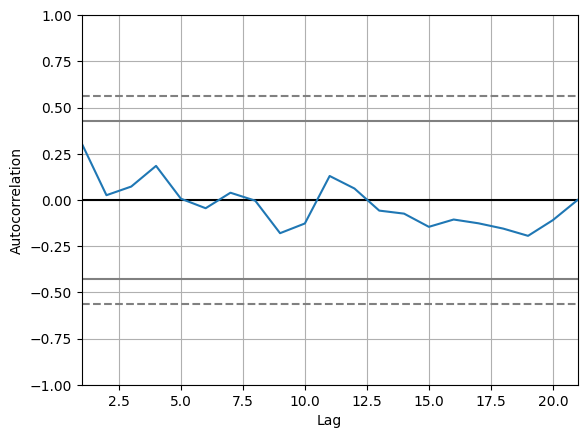

26994239326


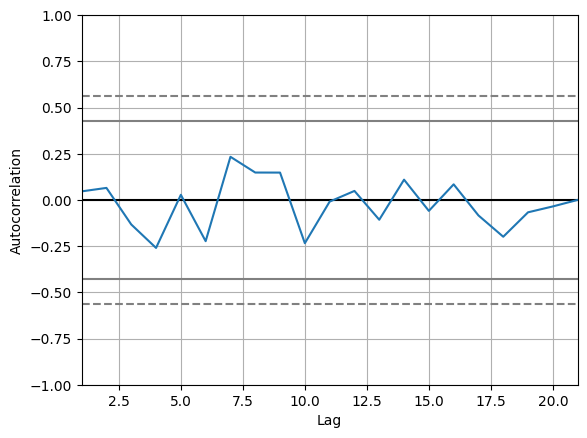

65022194603


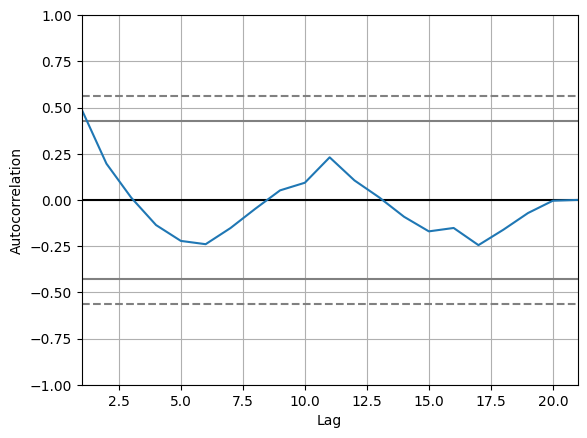

68252147715


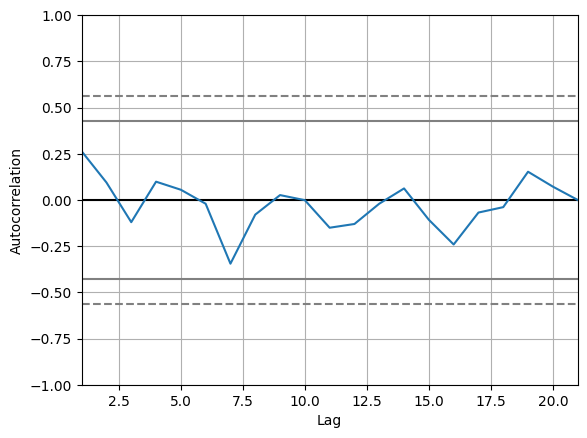

90477374366


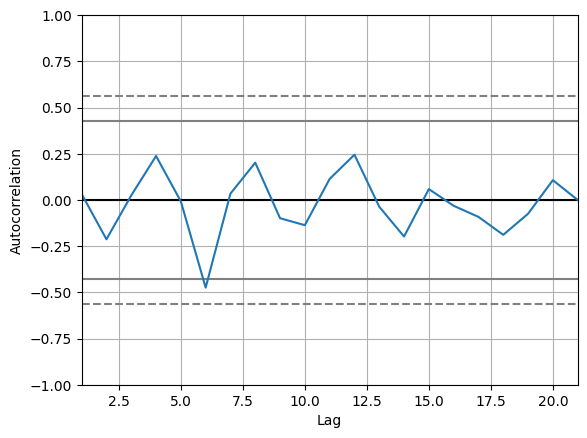

In [10]:
# We plot the autocorrelation for 5 random merchants

random.seed(4302022)

for i in range(5):
    random_merchant = random.sample(merchant_abns.tolist(), 1)[0]
    
    print(random_merchant)
    
    filtereddf = df[df[random_merchant] == 1][['int_month', 'monthly_profit']]
    filtereddf = filtereddf.sort_values('int_month')
    filtereddf = filtereddf['monthly_profit']
    
    x = pd.plotting.autocorrelation_plot(filtereddf)
 
    x.plot()
 
    plt.show()


For the reasons outlined in notebook 4.1, as well as for the sake of consistency, we again utilise 2 lags for this model.

In [11]:
# Create new field merchant_abn_class, a number between 0-4017 representing a single merchant_abn 

indexer = StringIndexer(inputCol='merchant_abn', outputCol='merchant_abn_class')
indexer_fitted = indexer.fit(modeldf)
modeldf = indexer_fitted.transform(modeldf)
modeldf

merchant_abn,int_month,monthly_profit,merchant_abn_class
35344855546,19,192.27,1181.0
38700038932,11,25783.11,1327.0
60654402457,5,12.96,2279.0
78916025936,13,10.0,3108.0
61867784114,3,87.01,2323.0
37470904997,14,0.0,1270.0
46331355995,7,2134.4,1668.0
35927874515,2,2110.72,1214.0
14316652139,8,233.55,190.0
60616659469,6,643.28,2275.0


In [12]:
# Complete one hot encoding of merchant_abn

encoder = OneHotEncoder(inputCols=['merchant_abn_class'], outputCols=['merchant_abn_ohe'])
modeldf = encoder.fit(modeldf).transform(modeldf)
modeldf

merchant_abn,int_month,monthly_profit,merchant_abn_class,merchant_abn_ohe
35344855546,19,192.27,1181.0,"(4017,[1181],[1.0])"
38700038932,11,25783.11,1327.0,"(4017,[1327],[1.0])"
60654402457,5,12.96,2279.0,"(4017,[2279],[1.0])"
78916025936,13,10.0,3108.0,"(4017,[3108],[1.0])"
61867784114,3,87.01,2323.0,"(4017,[2323],[1.0])"
37470904997,14,0.0,1270.0,"(4017,[1270],[1.0])"
46331355995,7,2134.4,1668.0,"(4017,[1668],[1.0])"
35927874515,2,2110.72,1214.0,"(4017,[1214],[1.0])"
14316652139,8,233.55,190.0,"(4017,[190],[1.0])"
60616659469,6,643.28,2275.0,"(4017,[2275],[1.0])"


In [13]:
# Create the lagged variables

partition = Window.partitionBy("merchant_abn").orderBy("int_month")
modeldf = modeldf.withColumn('monthly_profit-1', lag('monthly_profit', 1).over(partition))
modeldf = modeldf.withColumn('monthly_profit-2', lag('monthly_profit', 2).over(partition))
modeldf.show(60)

+------------+---------+--------------+------------------+----------------+----------------+----------------+
|merchant_abn|int_month|monthly_profit|merchant_abn_class|merchant_abn_ohe|monthly_profit-1|monthly_profit-2|
+------------+---------+--------------+------------------+----------------+----------------+----------------+
| 10023283211|        1|          1.26|               0.0|(4017,[0],[1.0])|            null|            null|
| 10023283211|        2|         42.36|               0.0|(4017,[0],[1.0])|            1.26|            null|
| 10023283211|        3|         45.01|               0.0|(4017,[0],[1.0])|           42.36|            1.26|
| 10023283211|        4|          47.9|               0.0|(4017,[0],[1.0])|           45.01|           42.36|
| 10023283211|        5|          45.3|               0.0|(4017,[0],[1.0])|            47.9|           45.01|
| 10023283211|        6|         47.19|               0.0|(4017,[0],[1.0])|            45.3|            47.9|
| 10023283

In [14]:
# Remove the months without valid lagged variables

modeldf = modeldf.na.drop()
modeldf.count()

76342

Now we build our time series regression model, with our testing data being the final 3 months of the dataset.

In [15]:
SPLIT_MONTH = 18

# Prepare a features column for the model
vecAssembler = VectorAssembler(inputCols=['merchant_abn_ohe', 'int_month', 
                                          'monthly_profit-1', 
                                          'monthly_profit-2'], 
                               outputCol='features')

# Train test split
train = modeldf.filter(col('int_month') <= SPLIT_MONTH)
test = modeldf.filter(col('int_month') > SPLIT_MONTH)

# Apply transformation to both datasets
train = vecAssembler.transform(train)
test = vecAssembler.transform(test)
train

merchant_abn,int_month,monthly_profit,merchant_abn_class,merchant_abn_ohe,monthly_profit-1,monthly_profit-2,features
10023283211,3,45.01,0.0,"(4017,[0],[1.0])",42.36,1.26,"(4020,[0,4017,401..."
10023283211,4,47.9,0.0,"(4017,[0],[1.0])",45.01,42.36,"(4020,[0,4017,401..."
10023283211,5,45.3,0.0,"(4017,[0],[1.0])",47.9,45.01,"(4020,[0,4017,401..."
10023283211,6,47.19,0.0,"(4017,[0],[1.0])",45.3,47.9,"(4020,[0,4017,401..."
10023283211,7,49.2,0.0,"(4017,[0],[1.0])",47.19,45.3,"(4020,[0,4017,401..."
10023283211,8,50.78,0.0,"(4017,[0],[1.0])",49.2,47.19,"(4020,[0,4017,401..."
10023283211,9,60.3,0.0,"(4017,[0],[1.0])",50.78,49.2,"(4020,[0,4017,401..."
10023283211,10,67.36,0.0,"(4017,[0],[1.0])",60.3,50.78,"(4020,[0,4017,401..."
10023283211,11,67.22,0.0,"(4017,[0],[1.0])",67.36,60.3,"(4020,[0,4017,401..."
10023283211,12,43.1,0.0,"(4017,[0],[1.0])",67.22,67.36,"(4020,[0,4017,401..."


In [16]:
# Train model

lr = LinearRegression(featuresCol='features', labelCol='monthly_profit')
lrModel = lr.fit(train)

22/10/15 17:17:58 WARN Instrumentation: [4cf7228a] regParam is zero, which might cause numerical instability and overfitting.
22/10/15 17:17:58 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/15 17:17:58 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/10/15 17:17:59 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [17]:
# Predict values for test data to evaluate model 

predictions = lrModel.transform(test)
predictions

merchant_abn,int_month,monthly_profit,merchant_abn_class,merchant_abn_ohe,monthly_profit-1,monthly_profit-2,features,prediction
10023283211,19,59.96,0.0,"(4017,[0],[1.0])",61.68,54.1,"(4020,[0,4017,401...",132.4725961369549
10023283211,20,70.14,0.0,"(4017,[0],[1.0])",59.96,61.68,"(4020,[0,4017,401...",139.88463951352685
10023283211,21,61.56,0.0,"(4017,[0],[1.0])",70.14,59.96,"(4020,[0,4017,401...",154.2695878543691
10142254217,19,235.46,1.0,"(4017,[1],[1.0])",233.71,176.81,"(4020,[1,4017,401...",300.96889548917306
10142254217,20,230.3,1.0,"(4017,[1],[1.0])",235.46,233.71,"(4020,[1,4017,401...",307.7675029050876
10142254217,21,297.41,1.0,"(4017,[1],[1.0])",230.3,235.46,"(4020,[1,4017,401...",313.59715624590496
10165489824,19,178.2,2.0,"(4017,[2],[1.0])",0.0,682.77,"(4020,[2,4017,401...",58.89954354922885
10165489824,20,221.73,2.0,"(4017,[2],[1.0])",178.2,0.0,"(4020,[2,4017,401...",199.7009395975776
10165489824,21,0.0,2.0,"(4017,[2],[1.0])",221.73,178.2,"(4020,[2,4017,401...",223.14981074556374
10187291046,19,51.9,3.0,"(4017,[3],[1.0])",51.14,77.09,"(4020,[3,4017,401...",126.84339927657298


22/10/15 17:18:37 WARN DAGScheduler: Broadcasting large task binary with size 1364.3 KiB


60573599765


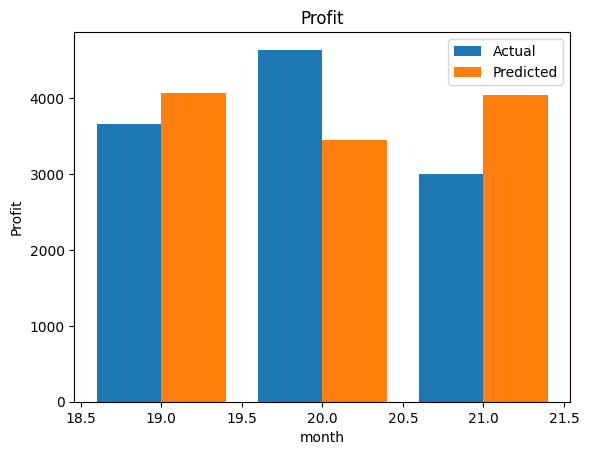

32943566946


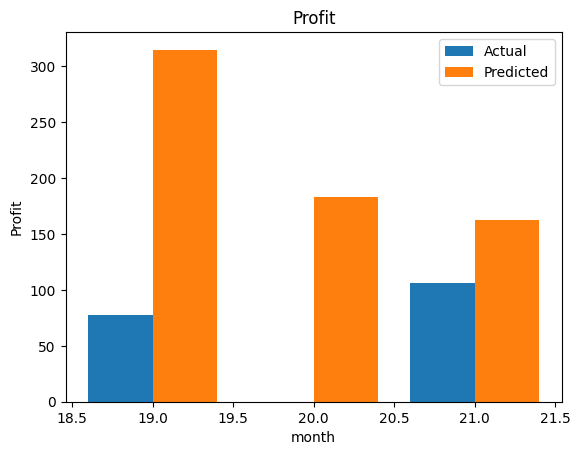

39211701585


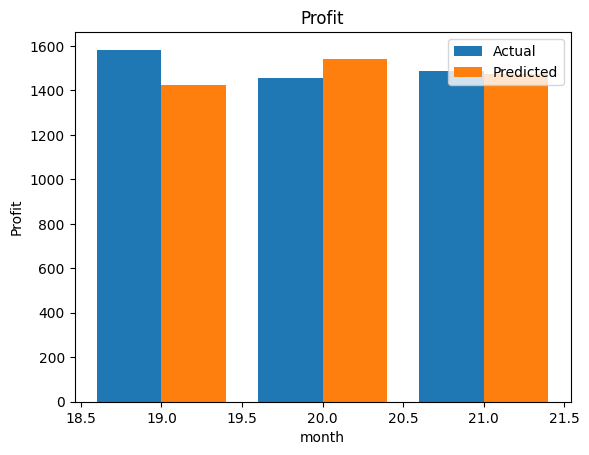

20877828351


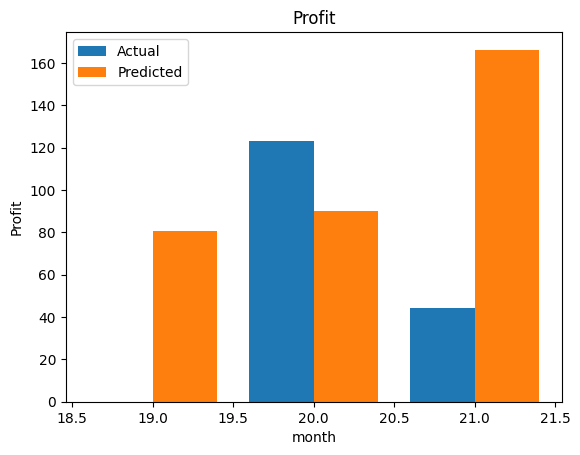

16644129035


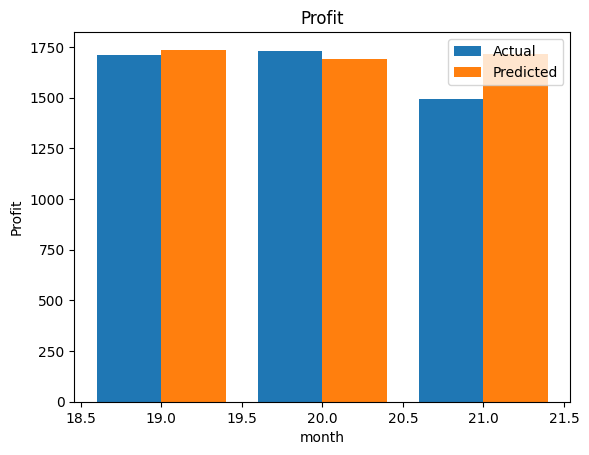

In [18]:
# Compare predictions and actual values for 5 random merchants

random.seed(4302023)

dfp = predictions.toPandas()
predictions.write.mode("overwrite").parquet("../data/curated/profit_merch_predictions.parquet")
X = [19, 20, 21]

for i in range(5):
    random_merchant = random.sample(merchant_abns.tolist(), 1)[0]
    print(random_merchant)
    X_axis = np.arange(19, 22)
    plt.bar(X_axis - 0.2, dfp[dfp['merchant_abn']==random_merchant]["monthly_profit"], 0.4, label = 'Actual')
    plt.bar(X_axis + 0.2, dfp[dfp['merchant_abn']==random_merchant]["prediction"], 0.4, label = 'Predicted')
    plt.legend()
    plt.xlabel('month')
    plt.ylabel('Profit')
    plt.title('Profit')
    plt.show()

In [19]:
# Mean Absolute Error

print(mae(dfp["monthly_profit"],  dfp["prediction"]))

191.4923477564675


# Simulation

Build up predictions until we reach 2023. This needs to be done somewhat manually since we require previous predictions to then be used as lagged variables for the next months predictions. 

**Expect total run time of the following code to take several minutes.**

In [23]:
pdf = predictions.select('merchant_abn', 'int_month', 'prediction', 'merchant_abn_ohe').toPandas()
pdf

,merchant_abn,int_month,prediction,merchant_abn_ohe
0,10023283211,19,132.472596,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,10023283211,20,139.884640,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,10023283211,21,154.269588,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,10142254217,19,300.968895,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,10142254217,20,307.767503,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
12049,99987905597,20,235.893626,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12050,99987905597,21,380.367826,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12051,99990536339,19,76.736766,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12052,99990536339,20,85.327298,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [21]:
# We build predictions for every merchant, one month at a time 
records = []
for int_month in range(22, 36):
    merchant_data = []
    
    # Build up required information for this month's prediction for all merchants
    for m in merchant_abns:
        merchant_abn_ohe = pdf.loc[(pdf['merchant_abn']==m) & (pdf['int_month']==21), 'merchant_abn_ohe'].values[0]
        merchant_data.append([m, merchant_abn_ohe, int_month, 
                              float(pdf.loc[(pdf['merchant_abn']==m) & 
                                            (pdf['int_month']==(int_month-2)), 'prediction'].values[0]),
                              float(pdf.loc[(pdf['merchant_abn']==m) & 
                                            (pdf['int_month']==(int_month-1)), 'prediction'].values[0])])     
    predictiondf = spark.createDataFrame(merchant_data, 
                                         schema=['merchant_abn', 'merchant_abn_ohe', 'int_month', 'monthly_profit-1', 
                                                 'monthly_profit-2'])
    
    # Now perform the predictions
    predictiondf = vecAssembler.transform(predictiondf)
    predictiondf = lrModel.transform(predictiondf)
    pdf = pd.concat([pdf, predictiondf.select('merchant_abn', 'int_month', 'prediction', 'merchant_abn_ohe').toPandas()])
    
    # Once we have reached 2023, start storing the predictions
    if int_month >= 24:
        for m in merchant_abns:
            records.append([2021 + (int_month//12), (int_month%12) + 1, m, 
                            float(pdf.loc[(pdf['merchant_abn']==m) & 
                                          (pdf['int_month']==(int_month)), 'prediction'].values[0])])

In [22]:
future_profit_sdf = spark.createDataFrame(records, schema=['year', 'month', 'merchant_abn', 'total_profit'])

future_profit_sdf.write.mode("overwrite").parquet("../data/curated/futureprofit.parquet/")

22/10/15 17:19:38 WARN MemoryManager: Total allocation exceeds 95.00% (1,929,039,029 bytes) of heap memory
Scaling row group sizes to 95.82% for 15 writers
22/10/15 17:19:38 WARN MemoryManager: Total allocation exceeds 95.00% (1,929,039,029 bytes) of heap memory
Scaling row group sizes to 89.83% for 16 writers
22/10/15 17:19:38 WARN MemoryManager: Total allocation exceeds 95.00% (1,929,039,029 bytes) of heap memory
Scaling row group sizes to 95.82% for 15 writers
